In [1]:
## Download and preprocess TF motifs from databases
## JASPAR 2024
## Filter PWMs from different experiments
## see 'runall' script in each databases/*/ folder for pre-preproccing steps.

## After pre-processing all of the invdividual databases run
##      bin/runall.tomtom.v2.0beta-human
## to compute the pair-wise similarity for all the motifs.
## Results are stored in 'results/tomtom'.


In [2]:
import pandas as pd
import numpy as np

In [3]:
# Import JASPAR2024 metadata

# These are the human only motifs; used the JASPAR search tool on website and downloaded all motifs from cart
jaspar2024 = !grep "MOTIF" databases/jaspar2024/JASPAR2024_CORE_vertebrates_mus_musculus_non-redundant_pfms_meme.meme | cut -d" " -f2

# Only get JASPAR motifs not in CIS-BP
# Note: some Taipale motifs are present in the JASPAR that might also be in CIS-BP

#jaspar_motifs = list(set(jaspar2024) - set(cisbp_df['source_id']))
jaspar_motifs = list(set(jaspar2024))

from pyjaspar import jaspardb
jdb_obj = jaspardb(release='JASPAR2024')

motif_id = []
dbid = []
tf_name = []
tf_family_name = []
pmid = []
motif_type = []

for m in jaspar_motifs:
    motif = jdb_obj.fetch_motif_by_id(m)
    
    motif_id.append(m)
    dbid.append(m)
    
    tf_name.append(motif.name)
    tf_family_name.append(motif.tf_class)
    pmid.append(motif.medline)
    motif_type.append('Unknown')
    
jaspar2024_df = pd.DataFrame(
    {
        'motif_id': motif_id,
        'source_id': dbid,
        'tf_name': tf_name,
        'family_name': tf_family_name,
        'motif_type': motif_type,
        'PMID': pmid
    }
).set_index('motif_id')

jaspar2024_df.iloc[:5,:]

,source_id,tf_name,family_name,motif_type,PMID
motif_id,,,,,
MA2095.1,MA2095.1,Sox7,[High-mobility group (HMG) domain factors],Unknown,15220343
MA0063.1,MA0063.1,Nkx2-5,[Homeo domain factors],Unknown,7797561
MA0160.1,MA0160.1,NR4A2,[Nuclear receptors with C4 zinc fingers],Unknown,17916232
MA0018.2,MA0018.2,CREB1,[Basic leucine zipper factors (bZIP)],Unknown,17916232
MA0100.1,MA0100.1,Myb,[Tryptophan cluster factors],Unknown,1861984


In [36]:
# Get filter motif from Grand et al. 2021

filters = !grep "MOTIF" databases/Enhancer_Filters/90CNN_synthetic_freq_score_TFBS.meme | cut -d" " -f2

motif_id = []
dbid = []
tf_name = []
tf_family_name = []
pmid = []
motif_type = []

for m in filters: 
    print(m)   
    motif_id.append(m)
    dbid.append(m)
    
    tf_name.append(m)
    tf_family_name.append('Unknown')
    pmid.append('Unknown')
    motif_type.append('Unknown')
    
filters_df = pd.DataFrame(
    {
        'motif_id': motif_id,
        'source_id': dbid,
        'tf_name': tf_name,
        'family_name': tf_family_name,
        'motif_type': motif_type,
        'PMID': pmid
    }
).set_index('motif_id')

filter0
filter1
filter2
filter3
filter4
filter5
filter6
filter7
filter8
filter9
filter10
filter11
filter12
filter13
filter14
filter15
filter16
filter17
filter18
filter19
filter20
filter21
filter22
filter23
filter24
filter25
filter26
filter27
filter28
filter29
filter30
filter31
filter32
filter33
filter34
filter35
filter36
filter37
filter38
filter39
filter40
filter41
filter42
filter43
filter44
filter45
filter46
filter47
filter48
filter49
filter50
filter51
filter52
filter53
filter54
filter55
filter56
filter57
filter58
filter59
filter60
filter61
filter62
filter63
filter64
filter65
filter66
filter67
filter68
filter69
filter70
filter71
filter72
filter73
filter74
filter75
filter76
filter77
filter78
filter79
filter80
filter81
filter82
filter83
filter84
filter85
filter86
filter87
filter88
filter89


In [37]:
#Combine motif metadata.

motifs = jaspar_motifs
motifs += filters 
print(len(motifs))

df_motif_info = pd.concat([jaspar2024_df, filters_df])
df_motif_info['motif_type'].value_counts()

404


motif_type
Unknown    314
Name: count, dtype: int64

In [38]:
df_motif_info.loc['MA0911.1']

source_id                    MA0911.1
tf_name                        Hoxa11
family_name    [Homeo domain factors]
motif_type                    Unknown
PMID                         18585359
Name: MA0911.1, dtype: object

In [39]:
# Load up the TOMTOM results
tomtom = pd.read_table('/pmglocal/ty2514/Enhancer/motif-clustering/bin/results/tomtom/tomtom.tsv').rename(columns={'Query_ID': 'Query ID','Target_ID': 'Target ID','Optimal_offset':'Optimal offset','Target_consensus':'Target consensus', 'Query_consensus': 'Query consensus'})
tomtom = tomtom.iloc[:-3,:] # Remove last three rows
sim = tomtom.pivot_table(index='Query ID', columns='Target ID', values='E-value', fill_value=np.nan)
cols = sim.columns.intersection(motifs)
rows = sim.index.intersection(motifs)

sim = sim[cols].loc[rows]

x = sim.values

w = np.triu(x) +  np.triu(x, 1).T
v = np.tril(x) + np.tril(x, -1).T

sim.iloc[:,:] = np.nanmin(np.dstack([w, v]), axis=2)

In [40]:
sim.fillna(100, inplace=True)
sim = -np.log10(sim)
sim[np.isinf(sim)] = 10

In [41]:
sim

Target ID,MA0002.2,MA0004.1,MA0006.1,MA0007.3,MA0009.1,MA0014.1,MA0018.2,MA0027.1,MA0029.1,MA0035.1,...,filter81,filter82,filter83,filter84,filter85,filter86,filter87,filter88,filter89,filter9
Query ID,,,,,,,,,,,,,,,,,,,,,
MA0002.2,19.215211,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,-2.0,-2.0,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
MA0004.1,-2.000000,5.495040,-0.449498,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,-2.0,-2.0,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
MA0006.1,-2.000000,-0.449498,5.385297,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,-2.0,-2.0,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
MA0007.3,-2.000000,-2.000000,-2.000000,23.726395,-2.000000,-2.000000,-2.0,-2.000000,-2.0,-2.0,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
MA0009.1,-2.000000,-2.000000,-2.000000,-2.000000,15.008904,-2.000000,-2.0,-2.000000,-2.0,-2.0,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
filter86,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,-2.0,-2.0,...,7.439310,-2.000000,8.717629,10.024696,-2.0,16.617383,-2.000000,10.024696,10.024696,8.199150
filter87,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-0.705592,-2.0,-2.000000,-2.0,-2.0,...,-2.000000,-0.484354,-2.000000,-2.000000,-2.0,-2.000000,38.921014,-2.000000,-2.000000,-2.000000
filter88,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-1.365565,-2.0,-2.0,...,10.773408,-2.000000,13.672516,16.872390,-2.0,10.024696,-2.000000,16.841873,16.854788,12.097443


In [42]:
# Cluster the square matrix

from scipy.cluster.hierarchy import fcluster, linkage, dendrogram

Z = linkage(sim, method = 'complete', metric = 'correlation')

cl = fcluster(Z, 0.7, criterion='distance')
o = dendrogram(Z, no_plot=True)['leaves']

print(f'Number of motif clusters: {max(cl)}')

motif_annot_df = pd.DataFrame({'motif_id':sim.index, 'cluster':cl}).merge(df_motif_info.reset_index(), on='motif_id', how='left').set_index('motif_id')
motif_annot_df['cluster'] = 'AC' + motif_annot_df['cluster'].astype(str).str.zfill(4)
motif_annot_df.head()

Number of motif clusters: 120


,cluster,source_id,tf_name,family_name,motif_type,PMID
motif_id,,,,,,
MA0002.2,AC0065,MA0002.2,Runx1,[Runt domain factors],Unknown,8413232
MA0004.1,AC0106,MA0004.1,Arnt,[Basic helix-loop-helix factors (bHLH)],Unknown,7592839
MA0006.1,AC0108,MA0006.1,Ahr::Arnt,"[Basic helix-loop-helix factors (bHLH), Basic ...",Unknown,7592839
MA0007.3,AC0086,MA0007.3,Ar,[Nuclear receptors with C4 zinc fingers],Unknown,20943813
MA0009.1,AC0115,MA0009.1,Tbxt,[T-Box factors],Unknown,8344258


In [43]:
#motif_annot_df.to_csv('results/JASPAR2024_cluster_anno.csv')
motif_annot_df[motif_annot_df['source_id'] == 'MA0911.1']

,cluster,source_id,tf_name,family_name,motif_type,PMID
motif_id,,,,,,
MA0911.1,AC0047,MA0911.1,Hoxa11,[Homeo domain factors],Unknown,18585359


In [44]:
# Step 1: Convert lists in 'family_name' to strings
df_to_save = motif_annot_df.copy()
df_to_save['family_name'] = df_to_save['family_name'].apply(lambda x: '/'.join(x) if isinstance(x, list) else x)

# Step 2: Define a function to create the cluster_annotation
def annotate_cluster(group):
    unique_families = group['family_name'].unique()
    annotation = '/'.join(unique_families)
    group['cluster_annotation'] = annotation
    return group

# Step 3: Apply the function to each group
df_to_save = df_to_save.groupby('cluster').apply(annotate_cluster)

# Step 4: Reset the index if needed (depends on your original DataFrame structure)
motif_annot_df2 = df_to_save.reset_index(drop=True)
motif_annot_df2.to_csv('bin/results/JASPAR2024_Filter_cluster.csv')

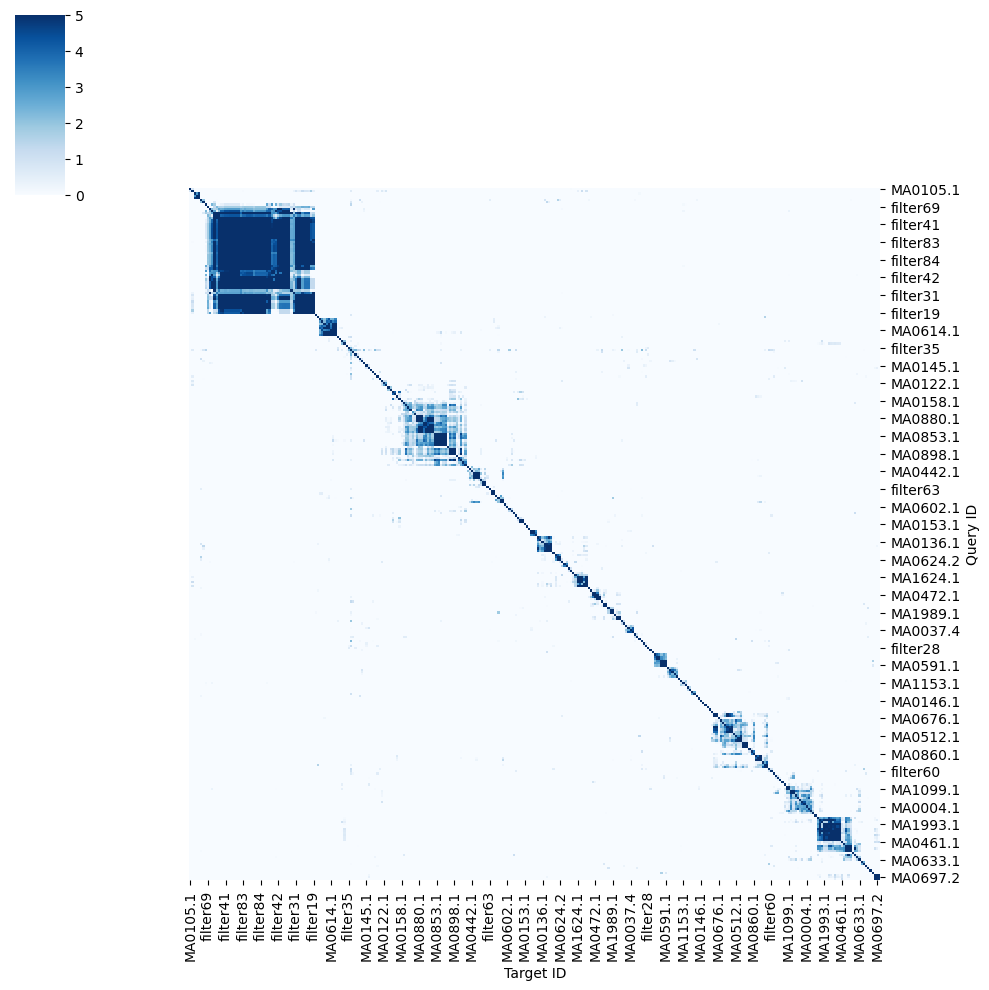

In [12]:
# Heatmap plot

import matplotlib.pyplot as plt
import seaborn as sns

sns.clustermap(sim.iloc[o,o], vmin=0, vmax=5, row_cluster=False, col_cluster=False, cmap='Blues')

plt.savefig('bin/results/heatmap.png')

In [30]:
def relative_info_content(pwm):
    p = pwm/np.sum(pwm, axis = 1)[:,np.newaxis]
    ic = 2+np.sum(p*np.nan_to_num(np.log2(p)), axis = 1)
    ric = p*ic[:,np.newaxis]
    return ric


def rev_compl(st):
    nn = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return "".join(nn[n] for n in reversed(st))

import warnings
warnings.filterwarnings('ignore')

def abs_mean(x):
    return np.mean(np.abs(x))

def process_cluster(df, tomtom_df):
    
    import os.path
    
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as mgridspec
    
    from genome_tools.plotting import sequence
    

    motifs = df.index

    rows = (tomtom_df['Query ID'].isin(motifs)) & (tomtom_df['Target ID'].isin(motifs))
    all_pairwise_df = tomtom_df[rows]        
    
    # Seed motif has the best optimal offset in the group
    
    seed_motif = all_pairwise_df.groupby('Query ID').agg({'Overlap': abs_mean}).sort_values('Overlap', ascending=False).index[0]
    seed_motif = all_pairwise_df.groupby('Query ID').agg({'E-value': np.median}).sort_values('E-value', ascending=True).index[0]

    
    rows = (tomtom_df['Query ID'] == seed_motif) & (tomtom_df['Target ID'].isin(motifs))
    pairwise_df = tomtom_df[rows] 
    
    pivot_df = all_pairwise_df.pivot_table(index='Query ID', columns='Target ID', values='Optimal offset')
    q = pivot_df.loc[seed_motif]
    qi = q[~np.isnan(q)].index
    
    
    query = []
    target = []
    offset = []
    orientation = []
    target_consensus = []
    query_consensus = []
    
    for m in motifs.difference(pairwise_df['Target ID']):
        t = pivot_df[m]
        ti = t[~np.isnan(t)].index
        
        try:
            common_motif = (qi&ti)[0]
        except:
            print(f'ERROR: {m} no alignments available!')
            continue
            
        row_q = (all_pairwise_df['Query ID'] == seed_motif) & (all_pairwise_df['Target ID'] == common_motif)
        row_t = (all_pairwise_df['Query ID'] == common_motif) & (all_pairwise_df['Target ID'] == m)
        
        #print(all_pairwise_df[row_t|row_q])
        
        offset_q = all_pairwise_df[row_q]['Optimal offset'].iloc[0]
        offset_t = all_pairwise_df[row_t]['Optimal offset'].iloc[0]
        
        orientation_q = all_pairwise_df[row_q]['Orientation'].iloc[0]
        orientation_t = all_pairwise_df[row_t]['Orientation'].iloc[0]
        
        consensus_q = all_pairwise_df[row_q]['Query consensus'].iloc[0]
        
        consensus_tq = all_pairwise_df[row_t]['Query consensus'].iloc[0]
        consensus_tt = all_pairwise_df[row_t]['Target consensus'].iloc[0]
        
        offset_p = len(consensus_tt) - offset_t - len(consensus_tq)
        
        target.append(m)
        query_consensus.append(consensus_q)

        if orientation_t == orientation_q:
            orientation.append('+')
            target_consensus.append(consensus_tt)
            
            if orientation_t == '+':
                offset.append(offset_q+offset_t)
            else:
                offset.append(offset_p+offset_q)
        else:            
            orientation.append('-')
            target_consensus.append(rev_compl(consensus_tt))
            
            if orientation_q == '-':        
                offset.append(offset_p+offset_q)
            else:
                offset.append(offset_q+offset_t)
        
    z = pd.DataFrame({
        'Query ID': seed_motif,
        'Target ID': target,
        'Optimal offset': offset,
        'p-value': 0, 
        'E-value': 0,
        'q-value': 1,
        'Overlap': 0,
        'Query consensus': query_consensus,
        'Target consensus': target_consensus,
        'Orientation': orientation,
    })
    
    
    if len(z) > 0:
        pairwise_df = pd.concat([pairwise_df, z])
        #print(z)
    
    #print(len(motifs), z.shape[0], pairwise_df.shape[0])
    
    w = pairwise_df['Target consensus'].str.len()
    left = min(-pairwise_df['Optimal offset'])
    l_offset = -left - pairwise_df['Optimal offset']
    right = max(l_offset + w)
    r_offset = right - w - l_offset
    
    alignment_df = pairwise_df.drop(['Query ID', 'Optimal offset', 'p-value', 'E-value', 'q-value', 'Overlap', 'Query consensus'], axis=1)
    alignment_df.loc[:,'w'] = w
    alignment_df.loc[:,'l_offset'] = l_offset
    alignment_df.loc[:,'r_offset'] = r_offset
    alignment_df.columns = ['motif', 'consensus', 'strand', 'w', 'l_offset', 'r_offset']
    
    alignment_df.reset_index(drop=True, inplace=True)

    alignment_df = alignment_df.merge(df.reset_index(), left_on='motif', right_on='motif_id')
    
    alignment_df.sort_values(by='tf_name', inplace=True)
    alignment_df.reset_index(inplace=True)
    
    n = len(alignment_df)
    l = min(alignment_df['l_offset'])
    r = max(alignment_df['r_offset'] + alignment_df['w'])
    w = r - l
  
    summed_pwm = np.zeros((4, int(w), int(n)))
    
    for i, row in alignment_df.iterrows():
        
        motif_id = row['motif']
        rc = row['strand'] == '-'
        left = int(row['l_offset'])
        width = int(row['w'])

        motif_pfm = os.path.join('/pmglocal/ty2514/Enhancer/motif-clustering/bin/results/pfms/', motif_id + '.pfm')
        pwm = np.loadtxt(motif_pfm)
    
        if rc:
            pwm = pwm[::-1,::-1]
        

        extended_pwm = np.ones((4, int(w))) * 0.25
        extended_pwm[:,left:left+width] = pwm
            
        summed_pwm[:,:,i] += extended_pwm
        
    avg_pwm = np.nanmean(summed_pwm, axis=2).T
 
    ic = relative_info_content(avg_pwm)
    total_ic = ic.sum(axis=1)

    cdf = np.cumsum(total_ic)/np.sum(total_ic)
    s = np.where(cdf > 0.05)[0][0]
    e = np.where(cdf > 0.95)[0][0] + 1    

    avg_pwm = avg_pwm[s:e,:]
    
    ## plot
    
    fig = plt.figure()
    fig.set_size_inches((w+2)*.125+2, (n+1)*0.5+1)
    
    gs = mgridspec.GridSpec(n+1, 1)
    
    for i, row in alignment_df.iterrows():
        ax = fig.add_subplot(gs[i+1, :])
        
        motif_id = row['motif']
        rc = row['strand'] == '-'
        left = row['l_offset']
        width = row['w']

        motif_pfm = os.path.join('/pmglocal/ty2514/Enhancer/motif-clustering/bin/results/pfms/', motif_id + '.pfm')
        pwm = np.loadtxt(motif_pfm)
    
        if rc:
            pwm = pwm[::-1,::-1]
        
        sequence.seq_plot(relative_info_content(pwm.T), ax=ax, offset=left)

        ax.axvspan(l-1, s, fc='lightgrey', alpha=0.5)
        ax.axvspan(e, r+1, fc='lightgrey', alpha=0.5)
        
        ax.set_xlim(left=l-1, right=r+1)
        ax.set_ylim(bottom=0, top=2.1)

        ax.xaxis.set_visible(False)
        ax.set_yticks([])
        
        source_id = str(row['source_id'])
        source_id = source_id[:10] + '...' if len(source_id) > 10 else source_id
        tf_name = str(row['tf_name'])  + '(' + str(row['motif_type']) + ')'

        ax.set_ylabel(tf_name + '\n (' + source_id + ')', rotation=0, ha='right', va='center', fontname="IBM Plex Mono", fontsize='medium')

    # Archetype motif
    ax = fig.add_subplot(gs[0,:])

    sequence.seq_plot(relative_info_content(avg_pwm), ax=ax, offset=s)

    ax.set_xlim(left=l-1, right=r+1)
    ax.set_ylim(bottom=0, top=2.1)
    ax.xaxis.set_visible(False)
    ax.set_yticks([])

    ax.axvspan(s, e, fc='none', ec='r', lw=2, clip_on=False)
    [ax.spines[loc].set_visible(False) for loc in ['top', 'bottom', 'left', 'right']]

    ax.set_ylabel('Archetype\nconsensus', rotation=0, ha='right', va='center', fontname="IBM Plex Mono", fontsize='large', fontweight='bold', color='r')
    
    cluster_id = str(alignment_df['cluster'][0])
    gene_family = alignment_df['tf_name'].str.replace('[\-0-9]+$', '').value_counts().index[:2].str.cat(sep='/')
    dbd = alignment_df['family_name'].astype(str).value_counts().index[0].replace(' ', '_')
    cluster_name = cluster_id + ':' + gene_family + ':' + dbd

    figw, figh = fig.get_size_inches()
    height_frac = (figh-0.75)/figh
    
   
    
    gs.update(left=1-((figw-1.75)/figw), right=(figw-0.25)/figw, top=(figh-0.75)/figh, bottom=1-((figh-0.25)/figh))
    
    fig.suptitle(cluster_name.upper(), fontname="IBM Plex Mono", fontweight='bold', fontsize='large', y=1-(.5/figh), va='center')
    plt.savefig(f'bin/results/clusters/{cluster_id}.pdf')
    plt.savefig(f'bin/results/clusters/{cluster_id}.png')
    
    #
    w = avg_pwm.shape[0]
    
    fig = plt.figure()
    #fig.set_size_inches(w*0.125+0.5, 0.75)
    fig.set_size_inches(w*0.125, 0.5)
    
    figw, figh = fig.get_size_inches() 
    
    gs = mgridspec.GridSpec(1, 1)
    #gs.update(left=1-((figw-0.25)/figw), right=(figw-0.25)/figw, top=1-(0.25/figh), bottom=0)
    gs.update(left=0, right=1, top=1, bottom=0)

    ax = fig.add_subplot(gs[:,:])
    
    sequence.seq_plot(relative_info_content(avg_pwm), ax=ax)
    
    ax.set_xlim(left=0, right=w)
    ax.set_ylim(bottom=0, top=2.1)
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    [ax.spines[loc].set_visible(False) for loc in ['top', 'bottom', 'left', 'right']]
    
    plt.savefig(f'bin/results/clusters/logos/{cluster_id}.pdf')
    plt.savefig(f'bin/results/clusters/logos/{cluster_id}.png')
    
    header_line =  cluster_name + '\n'
    mat = pd.DataFrame(avg_pwm.T, index=['A:', 'C:', 'G:', 'T:']).to_string(header=False)
    return header_line + mat

In [31]:
cluster = 'AC0005'
# Ensure 'cluster' is not part of the index
#motif_annot_df.reset_index(inplace=True)
#a = motif_annot_df
df = motif_annot_df.groupby('cluster').get_group(cluster)

pwm = process_cluster(df, tomtom)

findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

In [32]:
plt.ioff()

import matplotlib.pyplot as plt

with open('/pmglocal/ty2514/Enhancer/motif-clustering/bin/results/consensus_pwms.uniprobe', 'w') as fh:
    
    for cluster, df in motif_annot_df.groupby('cluster'):
        print(cluster)
        consensus_pwm = process_cluster(df, tomtom)
        fh.write(consensus_pwm + '\n\n')

AC0001


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0002


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0003


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0004


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0005


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0006


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0007


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0008


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0009


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0010


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0011


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0012


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0013


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0014


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0015


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0016


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0017


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0018


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0019


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0020


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0021


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0022


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0023


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0024


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0025


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0026


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0027


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0028


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0029


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0030
ERROR: MA0151.1 no alignments available!


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0031


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0032


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0033


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0034


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0035


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0036


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0037


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0038


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0039


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0040


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0041


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0042


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0043


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0044


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0045


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0046


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0047


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0048


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0049


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0050


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0051


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0052


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0053


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0054


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0055


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0056


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0057
ERROR: MA2125.1 no alignments available!


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0058


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0059


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0060


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0061


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0062


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0063


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0064


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0065
ERROR: MA0483.1 no alignments available!


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0066


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0067


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0068


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0069


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0070


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0071


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0072


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0073


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0074


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0075


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0076


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0077


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0078


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0079


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0080


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0081


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0082


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0083
ERROR: MA1153.1 no alignments available!


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0084


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0085
ERROR: filter2 no alignments available!
AC0086


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0087


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0088
AC0089


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0090


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0091


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0092


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0093


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0094


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0095


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0096


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0097


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0098


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0099


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0100


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0101


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0102


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0103


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0104


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0105


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0106


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0107


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0108


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.


AC0109


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0110


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0111


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0112


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0113


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0114


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0115


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0116


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0117


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0118


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0119


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

AC0120


findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font family 'IBM Plex Mono' not found.
findfont: Font famil

In [33]:
# size = motif_annot_df.groupby('cluster').size()

terms = motif_annot_df.groupby('cluster').agg({'source_id': ' '.join, 'tf_name': ' '.join})
terms['n'] = motif_annot_df.groupby('cluster').size()
terms = terms[['n', 'source_id', 'tf_name']]

terms.sort_values(by='n', ascending=False).to_csv('results/clusters.txt', sep='\t', header=None, index=True)

In [34]:
# Make the archetype motif MEME file

!uniprobe2meme results/consensus_pwms.uniprobe > results/consensus_pwms.meme

Converted 172 motifs.
Skipped 0 motifs.


In [28]:
# Output final motif metadata table

motif_annot_df.to_csv('results/metadata.tsv', header=True, index=True, sep='\t')

In [1]:
motif_annot_df.head()

NameError: name 'motif_annot_df' is not defined

In [482]:
# Make the HTML files
!bash bin/runall.make-html